# **Uczenie Maszynowe - LAB2b - LIME**

Biblioteka LIME: https://github.com/marcotcr/lime (Dokumentacja API: https://lime-ml.readthedocs.io/en/latest/)

# **Wprowadzenie - pakiety**

Niezbędne pakiety i moduły na potrzeby wprowadzenia

In [1]:
import json
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch
from lime import lime_image
from PIL import Image
from skimage.segmentation import mark_boundaries
from torchvision import models, transforms

# Wprowadzenie - funkcje pomocnicze

Funkcja do wczytywania wskazanego obrazka oraz konwersji do palety RGB.

In [2]:
def get_image(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

Funkcja do przekształcania obrazka (zwróconego przez funkcję `get_image`) w tensor, akceptowalny na wejściu sieci neronowej.

In [3]:
def image_to_tensor(img):    
    transformer = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
    ])  
    return transformer(img).unsqueeze(0)

Funkcja używana przez LIME, przyjmuje na wejściu zbiór obrazków, a zwraca prawdopodobieństwa klas. Należy ją przekazać do `lime_image.LimeImageExplainer().explain_instance` przy użyciu `partial`, jako `partial(predict_batch, <model>)`, gdzie modelem w naszym wypadku będą sieci neuronowe. Przykłady użycia są zawarte w tym notebooku.

In [4]:
def predict_batch(model, images):
    model.eval()
    transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]) 
    ])   
    
    model.eval()
    batch = torch.stack(tuple(transformer(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probas = torch.nn.functional.softmax(logits, dim=1)
    return probas.detach().cpu().numpy()

Funkcja, która przekształca obrazek w format akceptowany na wejściu przez LIME. Przykłady użycia są zawarte w tym notebooku.

In [5]:
def lime_transformer(image):
    transformer = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])
    return np.array(transformer(image))

LIME jest głównie wykorzystywane do **wyjaśniania** predykcji tzw. czarnych skrzynek, czyli modeli nieinterpretowalnych. Idealnymi kandydatami są Głębokie Sieci Neuronowe, dlatego spróbujemy wyjaśnić niektóre predykcje gotowych modeli.

# **Model Inception-v3 - przygotowanie danych**
https://arxiv.org/abs/1512.00567

Plik `./data/imagenet_class_index.json` zawiera przypisanie klas obrazków do indeksów. Jest to istotne, ponieważ zwracane wyniki (np. wartości funkcji logit na wyjściu sieci neuronowych) wykorzystują to, zwracając wyniki w zadanej kolejności.

In [7]:
with open("./data/imagenet_class_index.json") as f:
    content = json.load(f)
    index_to_label = {
        int(index): data[1]
        for index, data in content.items()
    }

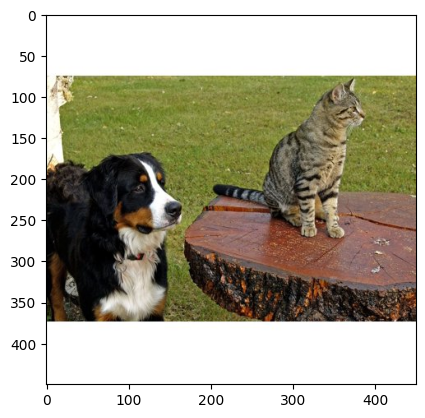

In [8]:
image_to_classify = get_image("./data/dogs.png")
plt.imshow(image_to_classify)

In [9]:
img_tensor = image_to_tensor(image_to_classify)

### **Załadowanie pretrenowanego modelu**

In [10]:
inception_v3 = models.inception_v3(pretrained=True)

/Users/jwasieleski/Prywatne/jul/workspace/uczenie-maszynowe/lab2/venv2/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jwasieleski/Prywatne/jul/workspace/uczenie-maszynowe/lab2/venv2/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /Users/jwasieleski/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:01<00:00, 97.2MB/s] 


### **Predykcja**

In [11]:
inception_v3.eval()
logits = inception_v3(img_tensor)

Zwróć uwagę, że model zwraca wartości funkcji logit, a nie prawdopodobieństwa klas, dlatego wyniki trzeba przetworzyć (np. przy użyciu funkcji softmax).

In [12]:
probas = torch.nn.functional.softmax(logits, dim=1)

Sprawdźmy N najbardziej prawdopodobnych klas

In [13]:
TOP_N_LABELS = 15

probas_top = probas.topk(TOP_N_LABELS)
top_probas = probas_top[0][0].detach().numpy()
top_labels = probas_top[1][0].detach().numpy()
for proba, label in zip(top_probas, top_labels):
    print(f"Class: {index_to_label[label]:<30} | Probability: {proba:.6f}")

Class: Bernese_mountain_dog           | Probability: 0.935931
Class: EntleBucher                    | Probability: 0.038448
Class: Appenzeller                    | Probability: 0.023756
Class: Greater_Swiss_Mountain_dog     | Probability: 0.001818
Class: Gordon_setter                  | Probability: 0.000009
Class: Blenheim_spaniel               | Probability: 0.000007
Class: English_springer               | Probability: 0.000002
Class: tabby                          | Probability: 0.000002
Class: robin                          | Probability: 0.000001
Class: guinea_pig                     | Probability: 0.000001
Class: amphibian                      | Probability: 0.000001
Class: Japanese_spaniel               | Probability: 0.000001
Class: African_grey                   | Probability: 0.000001
Class: Brittany_spaniel               | Probability: 0.000001
Class: toucan                         | Probability: 0.000001


### **Teraz możemy te funkcje zebrać razem**

In [14]:
def get_prediction_probabilities(image, model):
    img_tensor = image_to_tensor(image)
    model.eval()
    logits = model(img_tensor)
    probas = torch.nn.functional.softmax(logits, dim=1)
    
    TOP_N_LABELS = 15

    probas_top = probas.topk(TOP_N_LABELS)
    top_probas = probas_top[0][0].detach().numpy()
    top_labels = probas_top[1][0].detach().numpy()
    for proba, label in zip(top_probas, top_labels):
        print(f"Class: {index_to_label[label]:<30} | Probability: {proba:.6f}")

### **I sprawdzić jak ta predykcja wygląda dla innego obrazka**

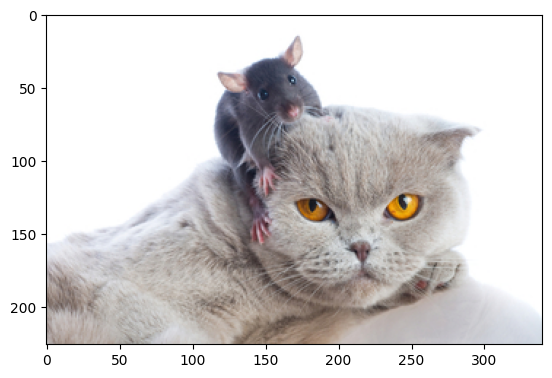

In [15]:
exercise_image = get_image("./data/cat_mouse.jpeg")
plt.imshow(exercise_image)

## **Zadanie: sprawdź jak będzie wyglądała predykcja dla powyższego obrazka**

In [16]:
get_prediction_probabilities(exercise_image, inception_v3)

Class: Egyptian_cat                   | Probability: 0.967492
Class: tabby                          | Probability: 0.024167
Class: lynx                           | Probability: 0.005490
Class: tiger_cat                      | Probability: 0.002165
Class: Persian_cat                    | Probability: 0.000105
Class: Angora                         | Probability: 0.000074
Class: swab                           | Probability: 0.000071
Class: Madagascar_cat                 | Probability: 0.000064
Class: snow_leopard                   | Probability: 0.000040
Class: tile_roof                      | Probability: 0.000037
Class: indri                          | Probability: 0.000020
Class: leopard                        | Probability: 0.000016
Class: Siamese_cat                    | Probability: 0.000011
Class: ram                            | Probability: 0.000010
Class: crate                          | Probability: 0.000009


# **Model Inception-v3 - wyjaśnienie**

Chcemy wiedzieć dlaczego klasa `Bernese_mountain_dog` została uznana przez sieć neuronową za najbardziej prawdopodobną (to znaczy - które piksele obrazka o tym zadecydowały). W tym celu właśnie wykorzystamy LIME.

W jaki sposób działa LIME na obrazkach?
1. Na wejściu wymagany jest oryginalny obrazek.
2. Wejściowy obrazek jest delikatnie przekształcany wiele razy, dzięki czemu otrzymujemy wiele podobnych (ale nie takich samych!) obrazków.
3. Dodatkowo na wejście musimy podać funkcję, która każdemu takiemu przekształceniu nada prawdopodobieństwo przynależności do danej klasy. Jest to wymagane ponieważ LIME jest niezależny od żadnych narzędzi i modeli.

In [17]:
explainer = lime_image.LimeImageExplainer()

In [18]:
explanation = explainer.explain_instance(
    image=lime_transformer(image_to_classify), 
    classifier_fn=partial(predict_batch, inception_v3),
    top_labels=5,
    num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Mając te dane możemy teraz sprawdzić które kategorie są najbardziej prawdopodobne

In [19]:
for index in explanation.top_labels:
    print(index_to_label[index])

Bernese_mountain_dog
EntleBucher
Appenzeller
Greater_Swiss_Mountain_dog
Gordon_setter


Zobaczmy co wpłynęło na wybranie `Bernese_mountain_dog` jako najbardziej prawdopodobnej klasy.

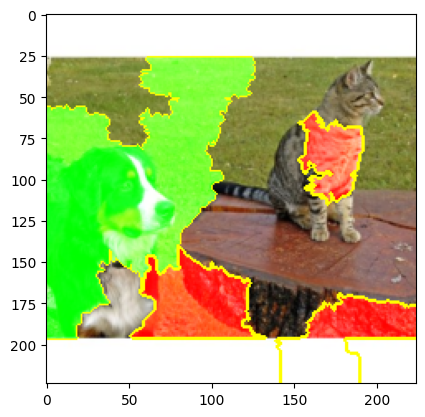

In [20]:
image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

## **Zadanie: zmień wartość NUM_FEATURES i zaobserwuj jak zmienia się mapowanie**
NUM_FEATURES najlepiej zmieniać w zakresie 1:50

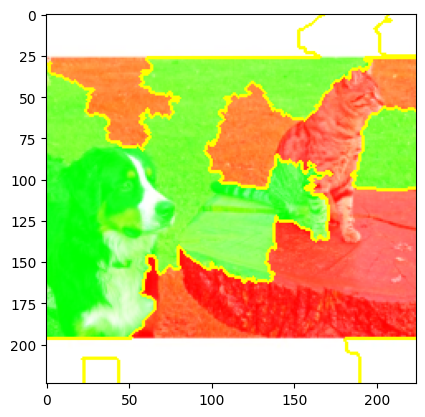

In [21]:
NUM_FEATURES = 50

image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=NUM_FEATURES,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

Zielone fragmenty oznaczają "superpiksele", które pozytywnie wpływają na predykowaną klasę. Czerwone fragmenty wpływają negatywnie.

## **Zadanie-pytanie: co to właściwie jest superpiksel?**
## **Zadanie-pytanie: czy jeden superpiksel ma odzwierciedlenie w jednym pikselu z obrazka?**

Zobaczmy jak to się prezentuje dla drugiej najbardziej prawdopodobnej klasy, czyli `EntleBucher`, która jednak otrzymała jedyne 3.8%.

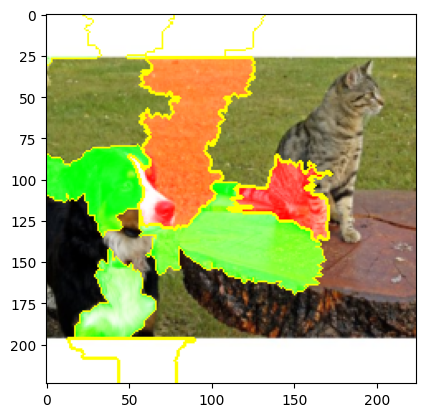

In [22]:
image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[1],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

Ustawiając wartości `hide_rest` oraz `positive_only` na `True` jesteśmy w stanie zostawić tylko te piksele, które potwierdzały przynależność do danej klasy <br>
Musimy jednak pamiętać o przeskalowaniu rezultatu przy pomocy `(boundaries).astype(np.uint8)`

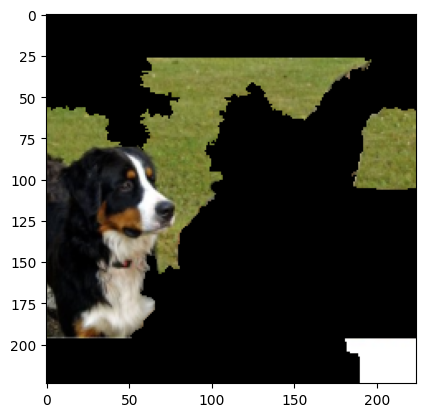

In [23]:
image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    negative_only=False,
    num_features=10,
    hide_rest=True)
boundaries = mark_boundaries(image, mask)
plt.imshow((boundaries).astype(np.uint8))

Możemy również zostawić tylko te piksele, które zaprzeczały przynależności do danej klasy

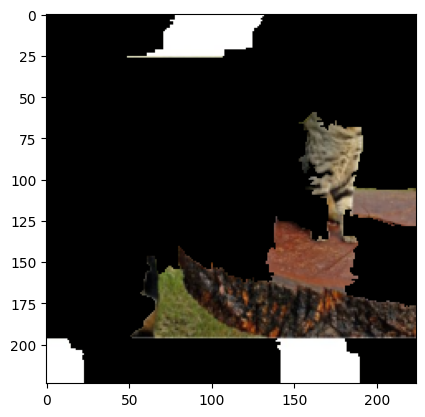

In [24]:
image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=False,
    negative_only=True,
    num_features=10,
    hide_rest=True)
boundaries = mark_boundaries(image, mask)
cropped_image_ndarray = (boundaries).astype(np.uint8)
plt.imshow(cropped_image_ndarray)

A następnie sprawdzić co model sądzi o tak wyciętym obrazku

In [25]:
cropped_image_pil = Image.fromarray(cropped_image_ndarray)

get_prediction_probabilities(cropped_image_pil, inception_v3)

Class: candle                         | Probability: 0.271928
Class: mortarboard                    | Probability: 0.227609
Class: groom                          | Probability: 0.199153
Class: academic_gown                  | Probability: 0.129570
Class: feather_boa                    | Probability: 0.022015
Class: cauliflower                    | Probability: 0.016281
Class: altar                          | Probability: 0.013093
Class: bow_tie                        | Probability: 0.010799
Class: conch                          | Probability: 0.004638
Class: suit                           | Probability: 0.003916
Class: teddy                          | Probability: 0.003420
Class: picket_fence                   | Probability: 0.003072
Class: stole                          | Probability: 0.003049
Class: cornet                         | Probability: 0.002686
Class: toy_poodle                     | Probability: 0.002659


I jak go teraz widzi model

In [26]:
cropped_image_explanation = explainer.explain_instance(
    image=lime_transformer(cropped_image_pil), 
    classifier_fn=partial(predict_batch, inception_v3),
    top_labels=5,
    num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

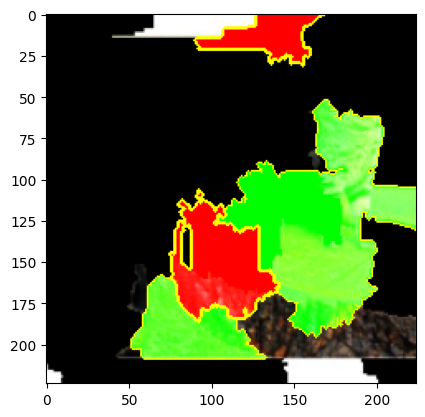

In [27]:
image, mask = cropped_image_explanation.get_image_and_mask(
    label=cropped_image_explanation.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

# **Model Inception-v3 - porównanie z AlexNet**

Przetestujmy działanie na innym modelu - `AlexNet`

In [28]:
alexnet = models.alexnet(pretrained=True)

/Users/jwasieleski/Prywatne/jul/workspace/uczenie-maszynowe/lab2/venv2/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jwasieleski/Prywatne/jul/workspace/uczenie-maszynowe/lab2/venv2/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /Users/jwasieleski/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:02<00:00, 103MB/s]  


In [29]:
explanation_alexnet = explainer.explain_instance(
    image=lime_transformer(image_to_classify), 
    classifier_fn=partial(predict_batch, alexnet),
    top_labels=5,
    num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [30]:
for index_alex, index_inception in zip(explanation_alexnet.top_labels, explanation.top_labels):
    print(f"{index_to_label[index_alex]:30} | {index_to_label[index_inception]:30}")

Bernese_mountain_dog           | Bernese_mountain_dog          
EntleBucher                    | EntleBucher                   
Greater_Swiss_Mountain_dog     | Appenzeller                   
Appenzeller                    | Greater_Swiss_Mountain_dog    
basset                         | Gordon_setter                 


Jak widać, klasy nieco się różnią, ale TOP 1 pozostaje takie samo.

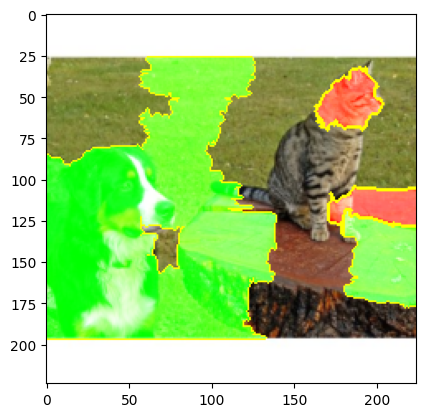

In [31]:
image, mask = explanation_alexnet.get_image_and_mask(
    label=explanation_alexnet.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

Wyjaśnienie dla `AlexNet` jak się można było spodziewać - też się różni, jednak w dalszym ciągu do klasyfikacji psa istotny jest... pies :)

## **Zadanie: porównaj predykcje obrazka dla modeli inception_v3 oraz alexnet**

In [32]:
print("inception_v3")
get_prediction_probabilities(image_to_classify, inception_v3)
print()
print("alexnet")
get_prediction_probabilities(image_to_classify, alexnet)

inception_v3
Class: Bernese_mountain_dog           | Probability: 0.935931
Class: EntleBucher                    | Probability: 0.038448
Class: Appenzeller                    | Probability: 0.023756
Class: Greater_Swiss_Mountain_dog     | Probability: 0.001818
Class: Gordon_setter                  | Probability: 0.000009
Class: Blenheim_spaniel               | Probability: 0.000007
Class: English_springer               | Probability: 0.000002
Class: tabby                          | Probability: 0.000002
Class: robin                          | Probability: 0.000001
Class: guinea_pig                     | Probability: 0.000001
Class: amphibian                      | Probability: 0.000001
Class: Japanese_spaniel               | Probability: 0.000001
Class: African_grey                   | Probability: 0.000001
Class: Brittany_spaniel               | Probability: 0.000001
Class: toucan                         | Probability: 0.000001

alexnet
Class: Bernese_mountain_dog           | Probabil

# **Zadanie domowe - wstęp**
W folderze `data` znajduje się zdjęcie amfibii:

![title](./data/amfibia.jpg)


In [33]:
amphibious_vehicle = get_image("./data/amfibia.jpg")

/Users/jwasieleski/Prywatne/jul/workspace/uczenie-maszynowe/lab2/venv2/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jwasieleski/Prywatne/jul/workspace/uczenie-maszynowe/lab2/venv2/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

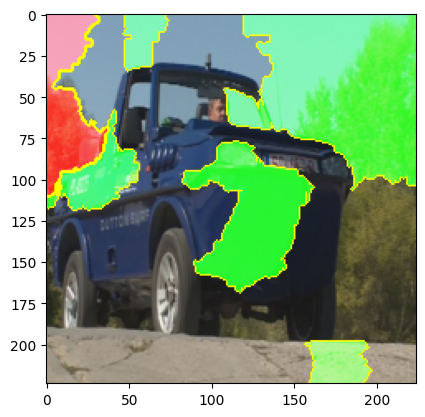

In [34]:
inception_v3 = models.inception_v3(pretrained=True)

explanation_amhibious_vehicle_inception_v3 = explainer.explain_instance(
    image=lime_transformer(amphibious_vehicle), 
    classifier_fn=partial(predict_batch, inception_v3),
    top_labels=5,
    num_samples=1000)

image, mask = explanation_amhibious_vehicle_inception_v3.get_image_and_mask(
    label=explanation_amhibious_vehicle_inception_v3.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

Model `inception_v3` jak i jego wyjaśnienie rzeczywiście sugerują amfibię jako najbardziej prawdopodobną klasę:

In [35]:
for index in explanation_amhibious_vehicle_inception_v3.top_labels:
    print(index_to_label[index])

amphibian
convertible
racer
car_wheel
golfcart


# Zadanie #1

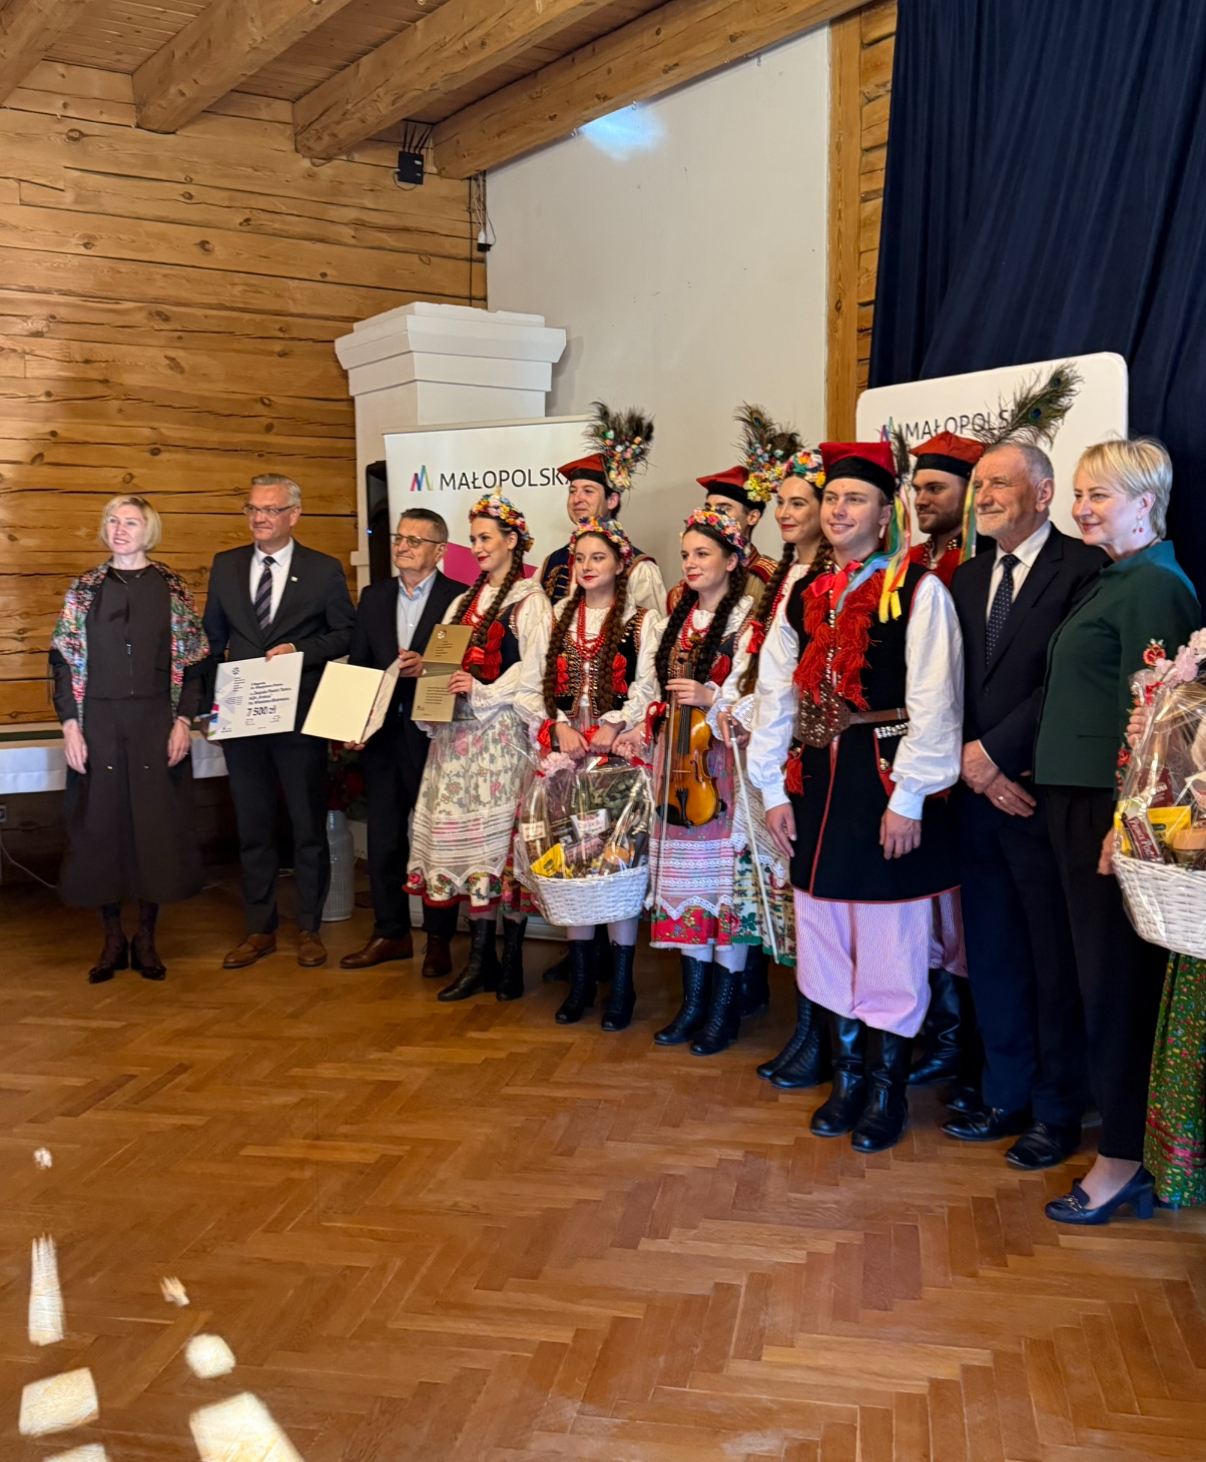

In [36]:
smartphone_image = get_image("./data/Nagroda_Wladyslawa_Orkana.jpeg")
smartphone_image

Użyj dwóch różnych sieci neuronowych (poza inception_v3, którego przykład jest powyżej) do wygenerowania wyjaśnień.<br>
(skorzystaj z modułu torchvision: https://pytorch.org/vision/stable/models.html)

In [37]:
resnet50 = models.resnet50(pretrained=True)
vgg16 = models.vgg16(pretrained=True)

/Users/jwasieleski/Prywatne/jul/workspace/uczenie-maszynowe/lab2/venv2/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jwasieleski/Prywatne/jul/workspace/uczenie-maszynowe/lab2/venv2/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/jwasieleski/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [01:14<00:00, 1.37MB/s]
/Users/jwasieleski/Prywatne/jul/workspace/uczenie-maszynowe/lab2/venv2/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/jwasieleski/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:05<00:00, 104MB/s]  


In [38]:
explanation_resnet50 = explainer.explain_instance(
    image=lime_transformer(smartphone_image),
    classifier_fn=partial(predict_batch, resnet50),
    top_labels=5,
    num_samples=1000,
)

print("Top 5 classes for ResNet50:")
for index in explanation_resnet50.top_labels:
    print(f"- {index_to_label[index]}")

print("\nResNet50 prediction probabilities:")
get_prediction_probabilities(smartphone_image, resnet50)

  0%|          | 0/1000 [00:00<?, ?it/s]

Top 5 classes for ResNet50:
- accordion
- vestment
- cornet
- bassoon
- academic_gown

ResNet50 prediction probabilities:
Class: accordion                      | Probability: 0.279537
Class: vestment                       | Probability: 0.237195
Class: cornet                         | Probability: 0.068222
Class: bassoon                        | Probability: 0.055786
Class: academic_gown                  | Probability: 0.043884
Class: oboe                           | Probability: 0.038013
Class: drum                           | Probability: 0.034143
Class: stage                          | Probability: 0.026521
Class: mortarboard                    | Probability: 0.020207
Class: flute                          | Probability: 0.020057
Class: trombone                       | Probability: 0.018959
Class: theater_curtain                | Probability: 0.016062
Class: sax                            | Probability: 0.011775
Class: groom                          | Probability: 0.011743
Class: vio

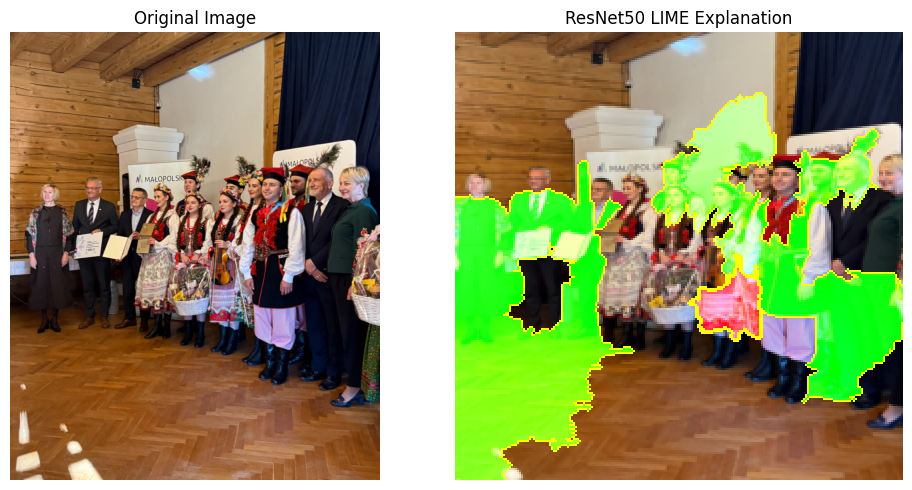

In [40]:
image_resnet50, mask_resnet50 = explanation_resnet50.get_image_and_mask(
    label=explanation_resnet50.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False,
)
boundaries_resnet50 = mark_boundaries(image_resnet50, mask_resnet50)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(smartphone_image)
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(boundaries_resnet50)
plt.title("ResNet50 LIME Explanation")
plt.axis('off')
plt.tight_layout()
plt.savefig("out/ResNet50.png", dpi=300, bbox_inches="tight")

In [41]:
explanation_vgg16 = explainer.explain_instance(
    image=lime_transformer(smartphone_image),
    classifier_fn=partial(predict_batch, vgg16),
    top_labels=5,
    num_samples=1000,
)

print("Top 5 classes for VGG16:")
for index in explanation_vgg16.top_labels:
    print(f"- {index_to_label[index]}")

print("\nVGG16 prediction probabilities:")
get_prediction_probabilities(smartphone_image, vgg16)

  0%|          | 0/1000 [00:00<?, ?it/s]

Top 5 classes for VGG16:
- bassoon
- stage
- oboe
- mortarboard
- academic_gown

VGG16 prediction probabilities:
Class: bassoon                        | Probability: 0.066854
Class: stage                          | Probability: 0.065927
Class: oboe                           | Probability: 0.061808
Class: mortarboard                    | Probability: 0.060670
Class: academic_gown                  | Probability: 0.056636
Class: flute                          | Probability: 0.044983
Class: panpipe                        | Probability: 0.030319
Class: cornet                         | Probability: 0.026772
Class: groom                          | Probability: 0.023959
Class: vestment                       | Probability: 0.023179
Class: drum                           | Probability: 0.021979
Class: accordion                      | Probability: 0.018997
Class: sax                            | Probability: 0.018972
Class: suit                           | Probability: 0.015778
Class: abaya       

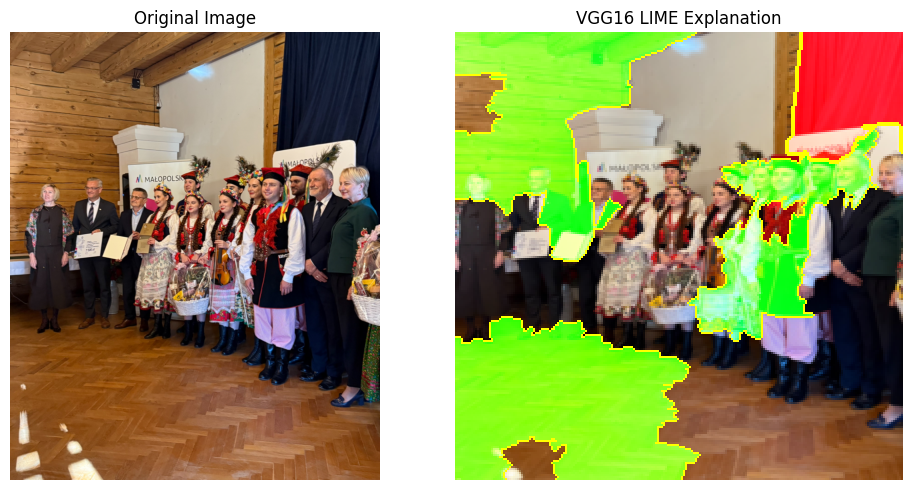

In [43]:
image_vgg16, mask_vgg16 = explanation_vgg16.get_image_and_mask(
    label=explanation_vgg16.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False,
)
boundaries_vgg16 = mark_boundaries(image_vgg16, mask_vgg16)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(smartphone_image)
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(boundaries_vgg16)
plt.title("VGG16 LIME Explanation")
plt.axis('off')
plt.tight_layout()
plt.savefig("out/VGG16.png", dpi=300, bbox_inches="tight")

=== Model Comparison ===
ResNet50 top class: accordion
VGG16 top class: bassoon


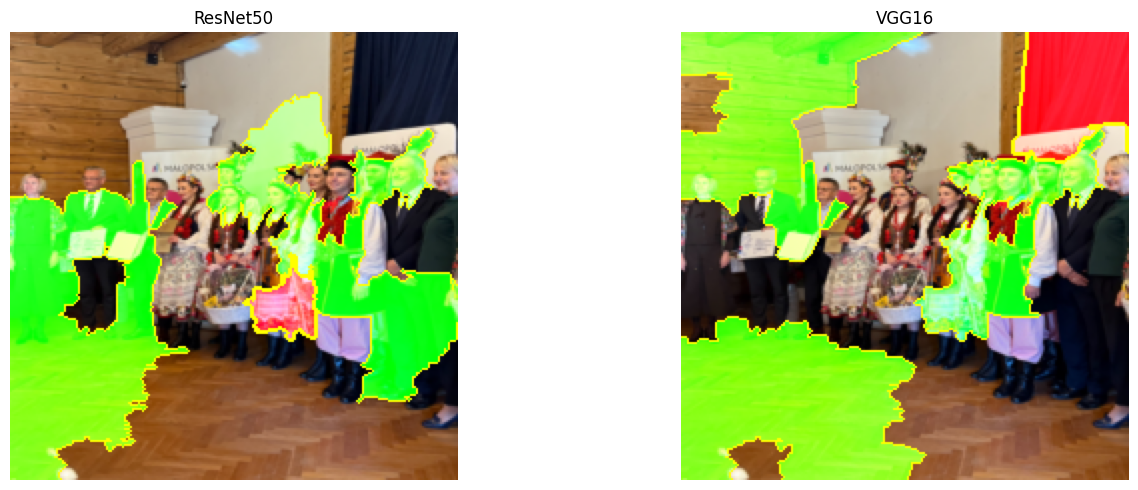

In [45]:
print("=== Model Comparison ===")
print("ResNet50 top class:", index_to_label[explanation_resnet50.top_labels[0]])
print("VGG16 top class:", index_to_label[explanation_vgg16.top_labels[0]])

# Create comparison visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(boundaries_resnet50)
plt.title("ResNet50")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(boundaries_vgg16)
plt.title("VGG16")
plt.axis('off')

plt.tight_layout()
plt.savefig("out/ResNet50vsVGG16.png", dpi=300, bbox_inches="tight")

# Zadanie #2

Zmodyfikuj oryginalny obrazek w taki sposób, żeby najbardziej prawdopodobną klasą dla każdej z tych sieci była inna niż poprzednio klasa. W tym celu możesz "zasłonić" czarnym kwadratem (wartość 0 w macierzy reprezentującej obraz) obszary istotne przy klasyfikacji. <br>
Przydatną rzeczą będzie skorzystanie z opcji `hide_rest` w funkcji `get_image_and_mask` i późniejsza obróbka obrazu

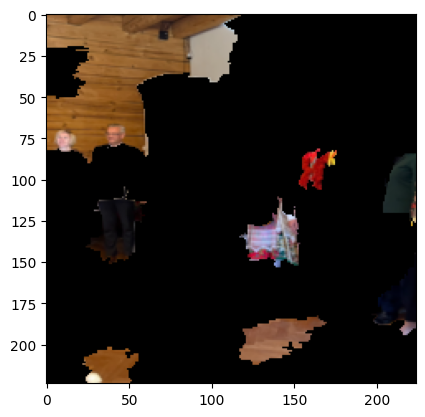

In [46]:
image_resnet50, mask_resnet50 = explanation_resnet50.get_image_and_mask(
    label=explanation_resnet50.top_labels[0],
    positive_only=False,
    negative_only=True,
    num_features=10,
    hide_rest=True,
)
boundaries = mark_boundaries(image_resnet50, mask_resnet50)
cropped_image_ndarray = boundaries.astype(np.uint8)
plt.imshow(cropped_image_ndarray)
plt.savefig("out/ResNet50-hidden.png", dpi=300, bbox_inches="tight")

In [47]:
cropped_image_pil = Image.fromarray(cropped_image_ndarray)

get_prediction_probabilities(cropped_image_pil, resnet50)

Class: castle                         | Probability: 0.203399
Class: stupa                          | Probability: 0.178989
Class: church                         | Probability: 0.052242
Class: cliff_dwelling                 | Probability: 0.042466
Class: bubble                         | Probability: 0.020533
Class: jigsaw_puzzle                  | Probability: 0.020456
Class: triumphal_arch                 | Probability: 0.018447
Class: palace                         | Probability: 0.016971
Class: balloon                        | Probability: 0.016810
Class: monastery                      | Probability: 0.014164
Class: umbrella                       | Probability: 0.013982
Class: cab                            | Probability: 0.013755
Class: groom                          | Probability: 0.013098
Class: violin                         | Probability: 0.010639
Class: obelisk                        | Probability: 0.009880


  0%|          | 0/1000 [00:00<?, ?it/s]

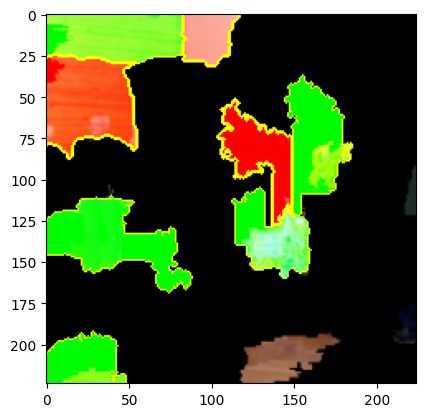

In [49]:
cropped_image_explanation = explainer.explain_instance(
    image=lime_transformer(cropped_image_pil),
    classifier_fn=partial(predict_batch, resnet50),
    top_labels=5,
    num_samples=1000,
)

image, mask = cropped_image_explanation.get_image_and_mask(
    label=cropped_image_explanation.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False,
)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)
plt.savefig("out/ResNet50-hidden-explained.png", dpi=300, bbox_inches="tight")

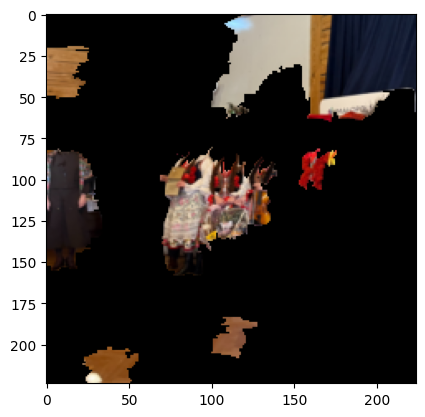

In [51]:
image_vgg16, mask_vgg16 = explanation_vgg16.get_image_and_mask(
    label=explanation_vgg16.top_labels[0],
    positive_only=False,
    negative_only=True,
    num_features=10,
    hide_rest=True,
)
boundaries = mark_boundaries(image_vgg16, mask_vgg16)
cropped_image_ndarray = boundaries.astype(np.uint8)
plt.imshow(cropped_image_ndarray)
plt.savefig("out/VGG16-hidden.png", dpi=300, bbox_inches="tight")

In [52]:
cropped_image_pil = Image.fromarray(cropped_image_ndarray)

get_prediction_probabilities(cropped_image_pil, vgg16)

Class: altar                          | Probability: 0.377884
Class: groom                          | Probability: 0.061813
Class: stupa                          | Probability: 0.053857
Class: torch                          | Probability: 0.053632
Class: picket_fence                   | Probability: 0.041231
Class: candle                         | Probability: 0.035511
Class: obelisk                        | Probability: 0.028906
Class: monastery                      | Probability: 0.025351
Class: triumphal_arch                 | Probability: 0.019705
Class: gown                           | Probability: 0.012749
Class: castle                         | Probability: 0.012740
Class: mortarboard                    | Probability: 0.011476
Class: conch                          | Probability: 0.009327
Class: vestment                       | Probability: 0.008867
Class: balloon                        | Probability: 0.008370


  0%|          | 0/1000 [00:00<?, ?it/s]

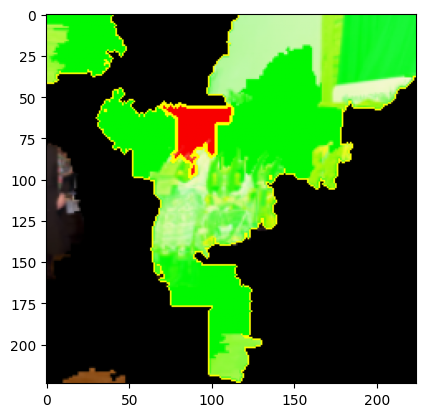

In [54]:
cropped_image_explanation = explainer.explain_instance(
    image=lime_transformer(cropped_image_pil),
    classifier_fn=partial(predict_batch, vgg16),
    top_labels=5,
    num_samples=1000,
)

image, mask = cropped_image_explanation.get_image_and_mask(
    label=cropped_image_explanation.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False,
)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)
plt.savefig("out/VGG16-hidden-explained.png", dpi=300, bbox_inches="tight")